In this notebook I show two methods to encode location features (longitude, latitude) to get a "neighborhood" proxy feature.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans

### Load dataset

In [2]:
df = pd.read_json('../input/train.json')[['longitude','latitude','interest_level','price']]
df['response'] = 0.
df.loc[df.interest_level=='medium', 'response'] = 0.5
df.loc[df.interest_level=='high', 'response'] = 1

### Outlier removal

If you take a look to the location coordinates you'll notice a few outliers far away from NY city center. I'll start by excluding them using a recursive approach. At each iteration all the listings with |z-score|>3 are excluded. The removal algorithm stops once all the listings have |z-score|<3.

Length before removing ouliers 49352
Length after removing ouliers 46946


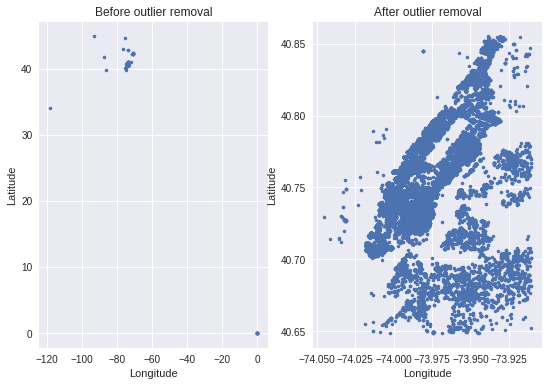

In [3]:
# Show location coordinates before oulier removal
fig, ax = plt.subplots(1, 2, figsize=(9,6))
print('Length before removing ouliers', len(df))
ax[0].plot(df.longitude, df.latitude, '.');
ax[0].set_title('Before outlier removal');
ax[0].set_xlabel('Longitude');
ax[0].set_ylabel('Latitude');
# Outlier removal
for i in ['latitude', 'longitude']:
    while(1):
        x = df[i].median()
        ix = abs(df[i] - x) > 3*df[i].std()
        if ix.sum()==0: # no more outliers -> stop
            break
        df.loc[ix, i] = np.nan # exclude outliers
# Keep only non-outlier listings
df = df.loc[df[['latitude', 'longitude']].isnull().sum(1) == 0, :]
print('Length after removing ouliers', len(df))
# Show location coordinates after outlier removal
ax[1].plot(df.longitude, df.latitude, '.');
ax[1].set_title('After outlier removal');
ax[1].set_xlabel('Longitude');
ax[1].set_ylabel('Latitude');

### Neighborhoods
Here, I'll use Kmeans to cluster listings based on their coordinates. I'll show the results of using 5, 10, 20 and 40 "neighborhoods".

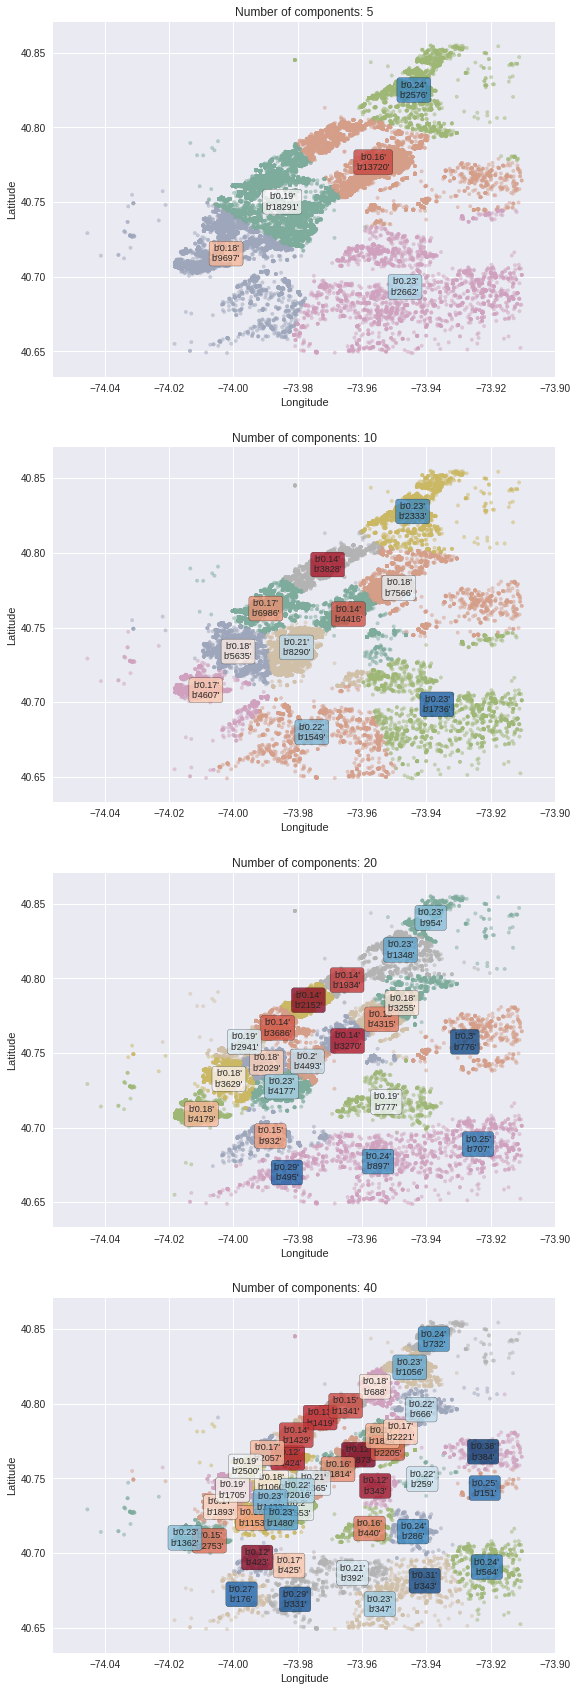

In [4]:
fig, ax = plt.subplots(4,1,figsize=(9,30))
for ix, ncomp in enumerate([5, 10, 20, 40]):
    r = KMeans(ncomp, random_state=1)
    # Normalize (longitude, latitude) before K-means
    temp = df[['longitude', 'latitude']].copy()
    temp['longitude'] = (temp['longitude']-temp['longitude'].mean())/temp['longitude'].std()
    temp['latitude'] = (temp['latitude']-temp['latitude'].mean())/temp['latitude'].std()
    # Fit k-means and get labels
    r.fit(temp[['longitude', 'latitude']])
    df['labels'] = r.labels_
    # Plot results
    cols = sns.color_palette("Set2", n_colors=ncomp, desat=.5)
    cl = [cols[i] for i in r.labels_]
    area = 12
    ax[ix].scatter(df.longitude, df.latitude, s=area, c=cl, alpha=0.5);
    ax[ix].set_title('Number of components: ' + str(ncomp))
    ax[ix].set_xlabel('Longitude')
    ax[ix].set_ylabel('Latitude')
    # Show aggregated volume and interest at each neighborhood
    x = df.groupby('labels')[['longitude','latitude','response']].mean().sort_values(['response'])
    x = pd.concat([x, df['labels'].value_counts()], axis=1).sort_values(['response'])
    cols = sns.color_palette("RdBu_r", ncomp)[::-1]
    for i in range(ncomp):
        props = dict(boxstyle='round', facecolor=cols[i], alpha=0.8)
        ax[ix].text(x.longitude.values[i], x.latitude.values[i], 
                str(np.array(np.round(x.response.values,2), '|S8')[i])+'\n'+str(np.array(x['labels'].values, '|S8')[i]), 
                fontsize=9, verticalalignment='center', horizontalalignment='center', bbox=props);

### Supervised encoding of location coordinates
The aim of this analysis is to provide a way to numericaly encode listing locations based on the mean location interest. I'll proceed as follows:

- Define a fixed grid of 40 points both for 'latitude' and 'longitude' values
- At each square defined by two consecutive longitude and latitude breaks compute the mean interest of the listings within the square

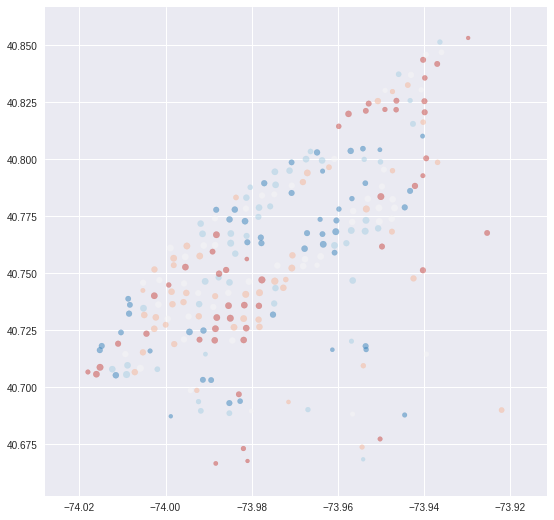

In [5]:
res = 40 # grid size
min_n = 30 # minimum size to perform inference
# Define grids
nx = np.linspace(df.longitude.min(), df.longitude.max(), res)
ny = np.linspace(df.latitude.min(), df.latitude.max(), res)
# Encode
Y = pd.DataFrame()
for i in range(res-1):
    for j in range(res-1):
        # Identify listings within the square
        ix = (df.longitude >= nx[i])&(df.longitude < nx[i+1])&(df.latitude >= ny[j])&(df.latitude < ny[j+1])
        # Compute mean interest if the number of listings is greated than 'min_n'
        if ix.sum() > min_n:
            y = df.loc[ix, :].mean() # mean interest
            y['n'] = ix.sum() # volume
            Y = pd.concat([Y, y], axis=1)
Y = Y.transpose()
# Show results
cols = sns.color_palette("RdBu_r", 5)
cl = [cols[i] for i in np.digitize(Y.response.values, Y.response.quantile(np.arange(1/5., 1, 1/5.)))]
area = 12 + 5*np.log1p(Y.n - min_n)
fig, ax = plt.subplots(1, 1, figsize=(9,9))
ax.scatter(Y.longitude, Y.latitude, s=area, c=cl, alpha=0.5);

Any feedback or comment will be appreciated! Upvote if you found it interesting :)

Thanks!